In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
import umap

## MNIST dataset

In [4]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [5]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [6]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [7]:
input_size = 784
output_size = 10

In [8]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [9]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [10]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [11]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Distance Embedding of the data

In [12]:
import dtnnlib as dtnn

In [30]:
NC = 1000
dt = dtnn.DistanceTransform_Exp(784, NC).to(device)
# dt.set_centroid_to_data_randomly(train_loader)
indices = np.random.permutation(len(train_loader.dataset.data))[:NC]
xx, yy_ = train_loader.dataset[indices]
dt.centers.data = xx.data.to(device)

indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

dists = dt(xx.to(device))

### Now embedding using UMAP

In [31]:
embedder = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1)

In [32]:
embedding = embedder.fit_transform(dt.centers.data.cpu().numpy())
embedding

array([[ 5.8659906 , 22.731047  ],
       [ 6.154806  , 21.422274  ],
       [ 0.7006937 , 21.160461  ],
       ...,
       [ 0.76242405, 18.979143  ],
       [ 3.0319407 , 22.537785  ],
       [ 4.8203125 , 24.086792  ]], dtype=float32)

In [43]:
embedding = embedding - embedding.mean(axis=0, keepdims=True)

In [44]:
output_cent = yy_.data.cpu().numpy()

In [45]:
i = 0

1/50


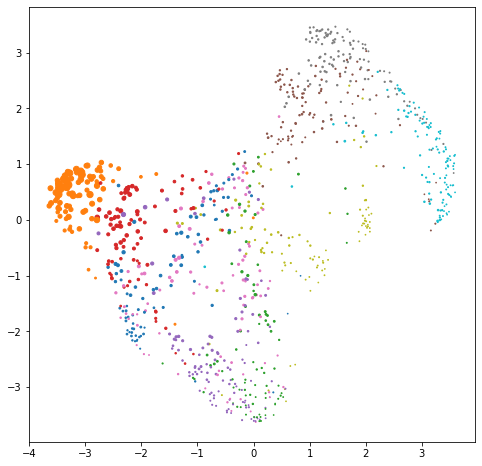

In [46]:
activ = dists.data.cpu().numpy()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
i += 1
print(f"{i}/{len(dists)}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*20, 0.5), cmap="tab10")

In [47]:
emb.mean(axis=0)

array([-6.8831446e-07,  2.9602052e-06], dtype=float32)

### Use the embedding to select Top-K neurons 

In [51]:
class SpatialAttention(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, out_neighbours, inp_neighbours, embedding_dim):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.out_neighbours = out_neighbours
        self.inp_neighbours = inp_neighbours
        
        embd_dim = embedding_dim
        self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim)/2)
        self.initialized = False
        
        self.W = None
        self.input_embedding = None
        
        lin = nn.Linear(num_inputs, num_outputs)
        self.weights = nn.Parameter(lin.weight.data.t())
#         self.bias = nn.Parameter(lin.bias.data)
        self.bn = nn.BatchNorm1d(num_outputs)
        self.hardness = 0.25
        
    def forward(self, x, input_embedding):
        if not self.initialized:
            mean, std = input_embedding.mean(dim=0, keepdims=True), input_embedding.std(dim=0, keepdims=True)
            self.output_embedding.data = torch.randn_like(self.output_embedding)*std+mean
            self.initialized = True
            
        self.input_embedding = input_embedding
        
        self.weights.data = torch.clamp(self.weights.data, -5, 5)
        ## take winning neuron for selecting neighbours
        winner = x.argmax(dim=1)

        #### take distance between embeddings
        edist = torch.cdist(input_embedding, self.output_embedding)
        
        #### first scale distance to generalized gaussian to select K-nearest neighbours
        A = self.hardness

        topk_edist, _ = torch.topk(edist, k=self.out_neighbours, dim=1, largest=False, sorted=True)
        edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
        b = 1/edge_dist + 1e-5
        scaler = torch.exp(-(edist**2 * b**2)**A)
        
        topk_edist1, _ = torch.topk(edist, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
        edge_dist1 = topk_edist1[-1:]
        b1 = 1/edge_dist1 + 1e-5
        scaler1 = torch.exp(-(edist**2 * b1**2)**A)
        
        
        self.W = scaler
        self.W1 = scaler1
        
        KM = scaler[winner]
        
        ## use this to scale the weights
        ytemp = torch.matmul(x, self.weights*scaler1)
#         y = ytemp*KM + self.bias
        y = self.bn(ytemp*KM)

        return y

In [52]:
sa = SpatialAttention(1000, 1000, out_neighbours=100, inp_neighbours=100, embedding_dim=2)

In [54]:
sa(dt(xx), torch.Tensor(emb)).shape

torch.Size([50, 1000])

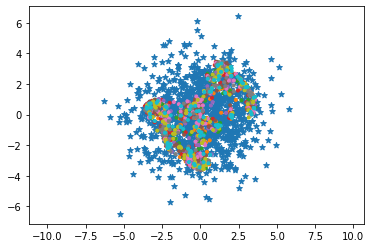

In [56]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.axis('equal')
plt.show()

### Forward propagate using the Spatial Attention

In [60]:
class SpatialMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        NC = 1000
        self.dt = dtnn.DistanceTransform_Exp(784, NC).to(device)
        self.dt.set_centroid_to_data_randomly(train_loader)
        
        self.input_embedding = torch.Tensor(emb)
        
        self.sa1 = SpatialAttention(1000, 1000, out_neighbours=100, inp_neighbours=100, embedding_dim=2)
        self.sa2 = SpatialAttention(1000, 1000, out_neighbours=100, inp_neighbours=100, embedding_dim=2)

        self.linear = nn.Linear(1000, 10)
        self.actf = nn.ELU()
        
    def forward(self, x):
        x = self.dt(x)
        x = self.sa1(x, self.input_embedding)
        x = self.actf(x)
        x = self.sa2(x, self.sa1.output_embedding)
        x = self.actf(x)
        x = self.linear(x)
        return x

In [61]:
model = SpatialMLP()

optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [62]:
index = 0
train_accs, test_accs = [], []
model.train()

## initial hardness is 0.25... increase [0.5, 1, 2, 4, 8]
hardness_double = [9, 18, 25, 31, 37]


for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
    if epoch in hardness_double:
        model.sa1.hardness *= 2
        model.sa2.hardness *= 2
        print(f"Hardness changed to {model.sa2.hardness}")
    
    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [04:57<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "./temp_01_2_model_nov26.pth")
torch.save(model.state_dict(), "./models/temp_01_2_model_nov26_v3.pth")

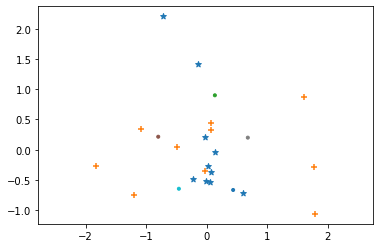

In [119]:
%matplotlib inline
plt.scatter(*sanet.input_embedding.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sanet.sa1.output_embedding.data.t(), marker='*')
plt.scatter(*sanet.sa2.output_embedding.data.t(), marker='+')

plt.axis('equal')
plt.show()

In [120]:
sanet.sa1.W

tensor([[3.9989e-07, 0.0000e+00, 9.6426e-01, 2.5145e-09, 0.0000e+00, 0.0000e+00,
         3.6784e-01, 9.6249e-01, 9.9670e-01, 1.0000e+00],
        [9.6979e-04, 3.1422e-14, 3.6780e-01, 9.9259e-01, 1.0000e+00, 9.9991e-01,
         7.5535e-01, 1.0139e-03, 8.9995e-04, 2.6333e-39],
        [9.1253e-01, 0.0000e+00, 3.6782e-01, 7.4771e-01, 2.7697e-32, 9.9247e-01,
         8.1982e-01, 2.1788e-01, 3.2528e-02, 0.0000e+00],
        [3.1076e-14, 0.0000e+00, 8.1563e-01, 9.9911e-01, 0.0000e+00, 9.8314e-01,
         8.7137e-01, 1.5796e-02, 1.2026e-01, 3.6783e-01],
        [9.9999e-01, 0.0000e+00, 4.5371e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.6784e-01, 9.8849e-01, 9.1003e-01, 0.0000e+00]],
       grad_fn=<ExpBackward>)

In [121]:
sanet.sa1.weights

Parameter containing:
tensor([[ 0.8513,  0.0650, -0.6873,  0.8715, -0.4176,  0.4804, -0.5678,  0.5431,
          0.7568,  0.8214],
        [-0.4557,  0.0720, -0.5140, -0.6430,  0.5589, -0.1292, -0.6333, -0.4197,
         -1.4233,  0.3846],
        [ 0.0190,  0.3440, -0.4186,  0.2404, -1.1374,  0.3560,  0.7369,  0.2152,
         -0.3343,  0.4301],
        [ 0.2074, -0.3527,  0.7872,  0.4400, -0.1693, -1.0149,  0.5680, -0.9858,
          0.1654, -0.0350],
        [-0.1949, -0.5864,  0.7682, -0.6953, -0.0709, -0.0802,  0.7884, -0.3425,
         -0.3377, -0.9347]], requires_grad=True)

In [122]:
line_collection = []
weight_collection = []

sa = sanet.sa2

saW = sa.W #W1
for i, inp in enumerate(sa.input_embedding):
    p0 = tuple(inp.tolist())
    for j, out in enumerate(sa.output_embedding):
        p1 = tuple(out.tolist())
        
        line_collection.append([p0,p1])
        weight_collection.append(float(saW[i,j]))
#         break
        
line_collection, weight_collection = np.array(line_collection), np.array(weight_collection)

In [123]:
line_collection

array([[[-0.22470936, -0.48173794],
        [ 1.78372133, -0.28390014]],

       [[-0.22470936, -0.48173794],
        [-1.20333934, -0.75360703]],

       [[-0.22470936, -0.48173794],
        [-1.82466173, -0.26915774]],

       [[-0.22470936, -0.48173794],
        [-0.48264396,  0.0475079 ]],

       [[-0.22470936, -0.48173794],
        [ 1.60836279,  0.87415165]],

       [[-0.22470936, -0.48173794],
        [ 0.07126519,  0.43774638]],

       [[-0.22470936, -0.48173794],
        [ 1.80030036, -1.06208217]],

       [[-0.22470936, -0.48173794],
        [-0.02761655, -0.35370997]],

       [[-0.22470936, -0.48173794],
        [-1.08683872,  0.33748984]],

       [[-0.22470936, -0.48173794],
        [ 0.0759415 ,  0.31914946]],

       [[-0.72864491,  2.20591116],
        [ 1.78372133, -0.28390014]],

       [[-0.72864491,  2.20591116],
        [-1.20333934, -0.75360703]],

       [[-0.72864491,  2.20591116],
        [-1.82466173, -0.26915774]],

       [[-0.72864491,  2.20591116],
  

In [124]:
weight_collection

array([0.00000000e+00, 3.67819458e-01, 0.00000000e+00, 9.99837518e-01,
       0.00000000e+00, 6.39197409e-01, 0.00000000e+00, 1.00000000e+00,
       3.77250240e-06, 9.37922418e-01, 8.26766094e-44, 8.99371400e-04,
       2.53340065e-01, 9.60154176e-01, 2.89018363e-01, 9.93331790e-01,
       0.00000000e+00, 3.67722958e-01, 9.95145857e-01, 9.83907640e-01,
       2.07591051e-23, 3.67800504e-01, 0.00000000e+00, 9.99972641e-01,
       0.00000000e+00, 9.99717236e-01, 0.00000000e+00, 1.00000000e+00,
       2.77584493e-01, 9.99978185e-01, 1.82740027e-29, 8.67267218e-08,
       0.00000000e+00, 9.99989152e-01, 0.00000000e+00, 9.99999881e-01,
       0.00000000e+00, 1.00000000e+00, 3.67804021e-01, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.74424481e-01,
       1.92296982e-01, 9.99896646e-01, 0.00000000e+00, 3.67774904e-01,
       9.65775609e-01, 9.99389589e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.99996841e-01, 0.00000000e+00, 1.00000000e+00,
      

In [125]:
weight_collection.min(), weight_collection.max()

(0.0, 1.0)

In [126]:
from matplotlib import collections
import matplotlib as mpl

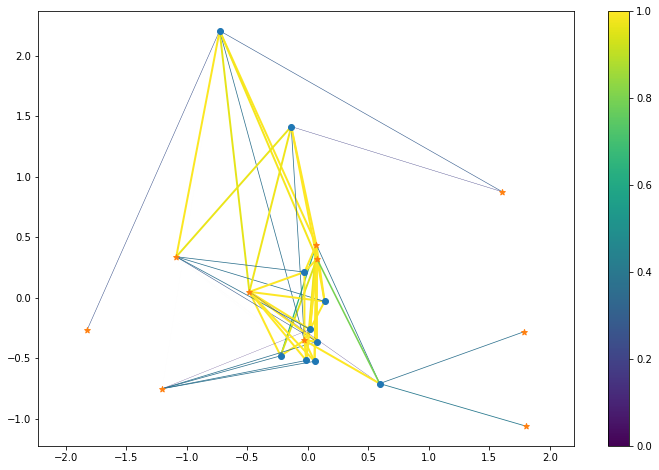

In [127]:
## plot attention weights
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# lc = collections.LineCollection(line_collection, linewidths=weight_collection*5, zorder=-2)
lc = collections.LineCollection(line_collection, 
                                array=weight_collection, 
                                linewidths= weight_collection*2, 
#                                 norm=mpl.colors.Normalize(vmin=-0, vmax=2),
#                                 cmap="PiYG", 
                                zorder=-2, )

# lc.set_array(weight_collection)
ax.add_collection(lc)
axcb = fig.colorbar(lc)

# ax.autoscale()
# ax.margins(0.1)

plt.scatter(*sa.input_embedding.data.t(), cmap='tab10', marker='o')
plt.scatter(*sa.output_embedding.data.t(), marker='*')

plt.axis('equal')
plt.show()

In [128]:
sa.hardness

8.0